# 1st Zermelo problem (with loss control / via augmentation)

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \mid 0.5 <x_2 < 3.5 \} \text{ is a loss control region.}
    \end{array}
    \right.
$$

In [2]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures

In [3]:
mutable struct Direct
  t ; t1 ; t2 ; x1 ; y1 ; x2 ; y2 ; x3 ; y3 ; u1 ; u2 ; u3 ; p1; p2; p3; q1; q2; q3
end

In [126]:
function ZERMELO(x0; solution=[], nsteps=400, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-6)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
    set_optimizer_attribute(sys,"max_iter",600)
    
    N  = nsteps                 # Grid size
    
    @variables(sys, begin
               x1[1:N+1]                
               y1[1:N+1]               
        -π/2 ≤ u1[1:N+1] ≤ π/2  # control   
            
               x2[1:N+1]                
               y2[1:N+1]               
        -π/2 ≤ u2[1:N+1] ≤ π/2  # state
            
               x3[1:N+1]                
               y3[1:N+1]                 
        -π/2 ≤ u3[1:N+1] ≤ π/2  # control
        
            
            0.0 ≤ t1  ≤ 8.0
            
            0.0 ≤ t2  ≤ 8.0


        end)
    
    Δt  =  1.0/(N+1) ; 
    
    # Objective
    @NLobjective(sys, Min, -x3[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]      == x0[1]              
        con_y10, y1[1]      == x0[2]  
        con_y1f, y1[N+1]    == 0.5
            
        con_x20, x2[1]      == x1[N+1]  
        con_y20, y2[1]      == 0.5
        con_y2f, y2[N+1]    == 3.5

            
        con_x30, x3[1]      == x2[N+1]  
        con_y30, y3[1]      == 3.5 
        con_x3f, y3[N+1]    == 4.0 

        con_t,     t2 - t1 >= 0                       
        
        con_u20, - π/2  ≤ u2[1]   ≤ π/2        
        con_u2f, - π/2  ≤ u2[N+1] ≤ π/2   
            
        end)
    
    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1],t1*(y1[j] + cos(u1[j])))
    @NLexpression(sys, dy1[j = 1:N+1],t1*sin(u1[j]))  
    
    @NLexpression(sys, dx2[j = 1:N+1],(t2 - t1)*(y2[j] + cos(u2[j])))
    @NLexpression(sys, dy2[j = 1:N+1],(t2 - t1)*sin(u2[j]))    
    @NLexpression(sys, du2[j = 1:N+1], 0.0)    
    
    @NLexpression(sys, dx3[j = 1:N+1],(8.0 - t2)*(y3[j] + cos(u3[j])))
    @NLexpression(sys, dy3[j = 1:N+1],(8.0 - t2)*sin(u3[j])) 

    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dy1[j=1:N], y1[j+1] == y1[j] + 0.5 * Δt * (dy1[j+1] + dy1[j])
        
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dy2[j=1:N], y2[j+1] == y2[j] + 0.5 * Δt * (dy2[j+1] + dy2[j])
        con_du2[j=1:N], u2[j+1] == u2[j]
        
        con_dx3[j=1:N], x3[j+1] == x3[j] + 0.5 * Δt * (dx3[j+1] + dx3[j])
        con_dy3[j=1:N], y3[j+1] == y3[j] + 0.5 * Δt * (dy3[j+1] + dy3[j])

        con_y1[j=1:N+1],        y1[j] <= 0.5 
        con_y2[j=1:N+1], 0.5 <= y2[j] <= 3.5 
        con_y3[j=1:N+1], 3.5 <= y3[j] 

     
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    y1 = value.(y1)[:]
    u1 = value.(u1)[:]
    
    x2 = value.(x2)[:]
    y2 = value.(y2)[:]
    u2 = value.(u2)[:]

    x3 = value.(x3)[:]
    y3 = value.(y3)[:]
    u3 = value.(u3)[:]
    
    t  = (0:N) * value.(Δt)
    t1 = value.(t1)
    t2 = value.(t2)
  
    
   px10 =   dual(con_x10)
   qy10 =   dual(con_y10) 
   qy1f = - dual(con_y1f) 
    
   px20 =   dual(con_x20)
   qy20 =   dual(con_y20) 
   qy2f = - dual(con_y2f) 
    
   px30 =   dual(con_x30)
   qy30 =   dual(con_y30) 
   qy3f = - dual(con_x3f)
    

   sign = 1
    
   px1 = [ dual(con_dx1[i]) for i in 1:N ]
   qy1 = [ dual(con_dy1[i]) for i in 1:N ]
    
   px2 = [ dual(con_dx2[i]) for i in 1:N ]
   qy2 = [ dual(con_dy2[i]) for i in 1:N ]
    
   px3 = [ dual(con_dx3[i]) for i in 1:N ]
   qy3 = [ dual(con_dy3[i]) for i in 1:N ]
    


   px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; 
   qy1 = sign * [qy10; (qy1[1:N-1]+qy1[2:N])/2.; qy1f]; 
    
   px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.]; 
   qy2 = sign * [qy20; (qy2[1:N-1]+qy2[2:N])/2.; qy2f];
    
   px3 = sign * [px30; (px3[1:N-1]+px3[2:N])/2.]; 
   qy3 = sign * [qy30; (qy3[1:N-1]+qy3[2:N])/2.; qy3f]; 

    
   p1 = - [px10; px1[1:N]]; 
   q1 = - [qy10; qy1[1:N-1]; qy1f]; 
    
   p2 = - [px20; px2[1:N]]; 
   q2 = - [qy20; qy2[1:N-1]; qy2f]; 
     
   p3 = - [px30; px3[1:N]]; 
   q3 = - [qy30; qy3[1:N-1]; qy3f]; 
  
    return Direct(t , t1 , t2 , x1 , y1 , x2 , y2 , x3 , y3 , u1 , u2 , u3, p1, p2, p3, q1, q2, q3)
        
end;

In [127]:
# Resolution
x0  = [0.0; 0.0]

direct_sol = ZERMELO(x0);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    16011
Number of nonzeros in inequality constraint Jacobian.:     1209
Number of nonzeros in Lagrangian Hessian.............:    23200

Total number of variables............................:     3611
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1205
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2809
Total number of inequality constraints...............:     1208
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:      401
        inequality constraints with only upper bounds:      804

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 4.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00

In [128]:
t  = direct_sol.t
t1 = direct_sol.t1
t2 = direct_sol.t2

tX1   = t .* t1
tX2   = t1*ones(length(t)) + t .* (t2-t1)
tX3   = t2*ones(length(t)) + t .* (8.0-t2);
t_all = vcat(tX1, tX2, tX3);

In [129]:
x1 = direct_sol.x1
x2 = direct_sol.x2
x3 = direct_sol.x3
x  = vcat(x1, x2, x3)

y1 = direct_sol.y1
y2 = direct_sol.y2
y3 = direct_sol.y3
y  = vcat(y1, y2, y3)

u1 = direct_sol.u1
u2 = direct_sol.u2
u3 = direct_sol.u3
u  = vcat(u1, u2, u3);

p1 = direct_sol.p1
p2 = direct_sol.p2
p3 = direct_sol.p3
p  = vcat(p1, p2, p3);

q1 = direct_sol.q1
q2 = direct_sol.q2
q3 = direct_sol.q3
q  = vcat(q1, q2, q3);


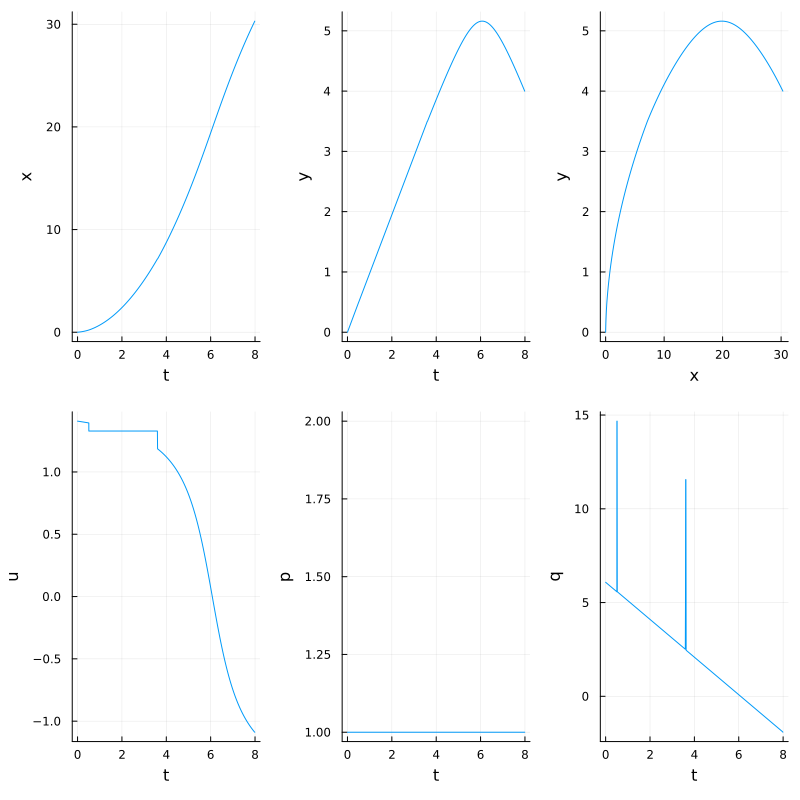

In [130]:
# Plots

x_plot   = plot(t_all, x,  xlabel = "t", ylabel = "x",  legend = false)
p_plot   = plot(t_all, p,  xlabel = "t", ylabel = "p",  legend = false)
q_plot   = plot(t_all, q,  xlabel = "t", ylabel = "q",  legend = false)


y_plot   = plot(t_all, y,  xlabel = "t", ylabel = "y",  legend = false)
u_plot    = plot(t_all, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) 
xy_plot = plot(x, y, xlabel = "x", ylabel = "y",  legend = false)

plot(x_plot, y_plot, xy_plot, u_plot, p_plot,q_plot, layout = (2,3), size=(800,800), left_margin=1mm)

In [131]:
index1 = findfirst(x -> x  == t1, t_all)
index2 = findfirst(x -> x  == t2, t_all)

803

In [133]:
jmp1 = q[index1+2]  - q[index1]
jmp2 = q[index2+2]  - q[index2];

# Indirect method 

In [134]:
using NLsolve
using Animations
using Reel
using Plots
using Plots.PlotMeasures
include("flow.jl");
using LinearAlgebra;

In [135]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [ sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region
H2(x, λ, y, p)   = p' * F(x, λ)   + y* p' *G(λ)          # pseudo-Hamiltonian
Hcl(X, P)     = H2(X[1:2], X[3], X[4], P[1:2])           # control loss

# Flows
fcl  = Flow(Hcl);

In [136]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]



# Shooting function
function shoot(p0, tt1, tt2, λ, jump1, jump2) 
    
    pλ0    = 0.0 
    
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    X2, P2 = fcl(tt1, [x1; λ ; 0.0], [p1 - [0. , jump1]; pλ0 ; py0], tt2) # flow augmenté
    
    xf, pf = fc(tt2, X2[1:2], P2[1:2] - [0. , jump2], tf)

    s = zeros(eltype(p0), 7)
    s[1]  = xf[2] - x2f # target
    s[2]  = pf[1] - 1.0 # transversality condition
    s[3]  = x1[2] - 0.5 # first crossing 
    s[4]  = X2[2] - 3.5 # second crossing 
    s[5]  = P2[4]       # averaged gradient condition
    s[6]  = jump1 - (p1[1]*(cos(λ) - cos(u11(x1, p1)))           + p1[2]*(sin(λ) - sin(u11(x1, p1))))/(sin(λ))                                              # jump 1
    s[7]  = jump2 - (P2[1]*(cos(u11(X2[1:2], P2[1:2])) - cos(λ)) + P2[2]*(sin(u11(X2[1:2], P2[1:2])) - sin(λ)))/(sin(u11(X2[1:2], P2[1:2])))                # jump 2

    
    return s

end;

In [137]:
S(ξ)    = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7]) ;

In [138]:
ξ_guess = [p[1], q[1], t1, t2, u2[1], jmp1 , jmp2 ]  # initial guess 
#ξ_guess = [p[1], q[1], t1, t2, u2[1],  -1.169104265276781,  0.43767443530207517]  # initial guess using the jump of the direct method (with no augmentation)

7-element Vector{Float64}:
  1.0
  6.079442070560287
  0.5085999400391856
  3.60690380993293
  1.3280953103538515
 -9.098641554365425
 -9.101868922308412

In [139]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[3.8953384102164756, 0.0, 0.0012539767959828252, 0.008753976795922824, 6.761911885819431, -9.086295591030813, -9.24432659651822]




In [140]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0   = indirect_sol.zero[1:2]
    tt1   = indirect_sol.zero[3]
    tt2   = indirect_sol.zero[4]
    a     = indirect_sol.zero[5]
    jmp11 = indirect_sol.zero[6]
    jmp22 = indirect_sol.zero[7]

else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.244327e+00              NaN
     1     1.749126e+02     3.580362e-15
     2     4.774160e+01     1.110223e-16
     3     1.424358e+01     0.000000e+00
     4     6.715754e+00     7.536145e+00
     5     1.360674e+01     2.220446e-16
     6     6.228911e+00     0.000000e+00
     7     9.922784e+00     0.000000e+00
     8     3.408422e+00     3.388171e+00
     9     2.698690e+00     4.520913e+00
    10     1.841986e-01     5.136091e+00
    11     5.258344e-04     6.718811e-02
    12     1.955509e-08     4.431962e-04
    13     1.740830e-13     5.556165e-09
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.079442070560287, 0.5085999400391856, 3.60690380993293, 1.3280953103538515, -9.098641554365425, -9.101868922308412]
 * Zero: [1.0, -6.571117314370255, -0.5062339352185802, 2.5657446562385644, 1.353896488246003, -12.138767928540

In [141]:
ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1 = ode_sol.t ;
xx1 = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1 = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1 = u11.(xx1, pp1)  ;

In [144]:
ode_sol = fcl((tt1, tt2), [xx1[end] ; a ; 0.0], [pp1[end] - [0. , jmp11]; 0. ; 0.], saveat=0.1)
ttt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2 = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2 = a.*ones(length(ttt2)) ;

In [143]:
ode_sol = fc((tt2, tf), xx2[end], pp2[end] - [0. , jmp22], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;

In [145]:
t = [ ttt1 ; ttt2 ; ttt3 ]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ];
m = length(t)
x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

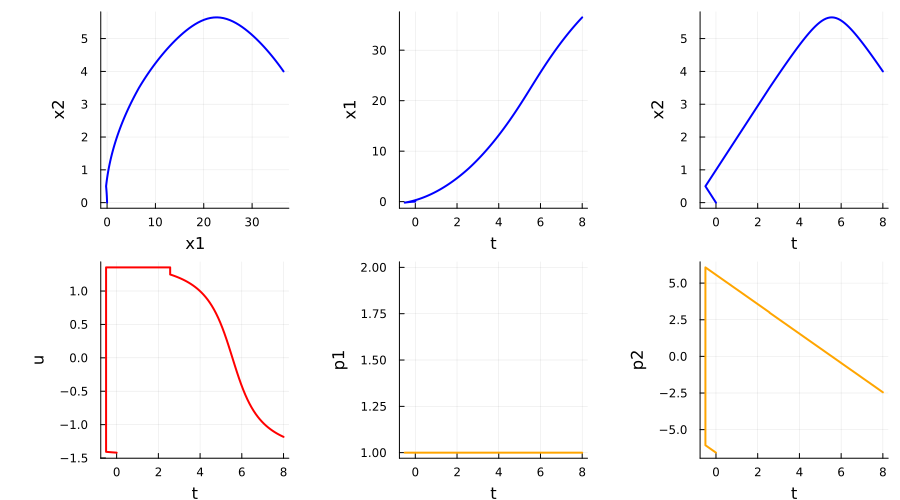

In [146]:
x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1", legend=false, linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", legend=false,linecolor=:blue,linewidth=2)


p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend=false,linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2",legend=false,linecolor=:orange,linewidth=2)

u_plot    = plot(t,   u, xlabel = "t", ylabel = "u", legend=false ,linecolor=:red ,linewidth=2) 

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend=false, linecolor=:blue,linewidth=2)


x = plot(x1x2_plot,x1_plot, x2_plot,u_plot,p1_plot, p2_plot , layout = (2, 3), size=(900, 500), left_margin=10mm)